In [ ]:
# !pip install spotipy

     |████████████████████████████████| 61kB 2.6MB/s 
     |████████████████████████████████| 153kB 8.2MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import spotipy
from google.colab import drive
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials
from spotipy.oauth2 import SpotifyClientCredentials

## Mount GDrive

In [ ]:
drive.flush_and_unmount()
drive.mount("/content/drive")

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


Check it

In [ ]:
%cd /content/drive/MyDrive/
!ls -htl | head

/content/drive/MyDrive
total 1.4G
drwx------ 2 root root 4.0K Apr 19 19:21 Colab Notebooks
-rw------- 1 root root  151 Apr 19 18:08 Копия genres.gsheet
-rw------- 1 root root  151 Apr 16 19:08 Проект 7: Метагеномы.gdoc
-r-------- 1 root root  151 Apr  3 19:00 Phylogenetic Mini-project.gslides
-rw------- 1 root root  151 Mar 30 12:58 Резюме.gdoc
-rw------- 1 root root  151 Mar 29 15:46 Резюме (1).gdoc
-rw------- 1 root root 449K Mar 28 01:26 красивый рисунок.png
-rw------- 1 root root  151 Mar 24 08:36 Проект 6: H+.gdoc
-rw------- 1 root root 1.2M Mar 22 10:02 APSOIL-D-21-00236_reviewer.pdf


## Read Genre table



Authenticate me in Google tables

In [ ]:
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

Import data



In [ ]:
sht2 = gc.open_by_url('https://docs.google.com/spreadsheets/d/1eC9WMRORSHYfUqa9woZIGfYGYYdY0PzvWWpcamvR5Cc/edit#gid=0').sheet1
rows = sht2.get_all_values()
headers = rows.pop(0)
df = pd.DataFrame.from_records(rows, columns=headers)
df.song

0                   Нет_мира_без_тебя-Ранетки
1      Bitch_Dont_Kill_My_Vibe-Kendrick_Lamar
2                       Precious-Depeche_Mode
3                     Ultima_Thule-Oxxxymiron
4                                  Unravel-TK
                        ...                  
347       The_Veldt-deadmau5_feat_Chris_James
348    The_Violent_Sequence-Worriedaboutsatan
349                      Voyager-Jasper_Byrne
350                               Youth-Baril
351               Chop_It-Savant_&_Gino_Sydal
Name: song, Length: 352, dtype: object

## Get features from API Spotify

In [ ]:
client_id = input("ID: ")
client_secret = input("secret: ")

In [ ]:
def get_info_from_spotify(name):
  """
  Get some Spotify features by name of the song (author and name should be delimeted by hyphen)
  name: name of the track in <author>-<track> format. Author and name should be delimeted by\
  hyphen, or will be ignored
  return: list of Spotify features
  """
  print(name)
    
  auth_manager=SpotifyClientCredentials(client_id=client_id,
                                                           client_secret=client_secret)
  sp = spotipy.Spotify(auth_manager=auth_manager)
    
  artist, track = name.split("-", maxsplit=1)
  artist = artist.replace("_", " ")
  track = track.replace("_", " ")
#     print(f'{artist} {track}')
  results = sp.search(q=f'{artist} {track}', type='track', limit=3)
#     print(results)
  if results['tracks']['items']:
      first_artist = results['tracks']['items'][0]['artists'][0]['name']
      first_track = results['tracks']['items'][0]['name']
      first_id = results['tracks']['items'][0]['id']
        
      info = sp.audio_features(first_id)[0]
      info['track'] = first_track
      info['artist'] = first_artist
      info['id'] = first_id
      info['source_name'] = name
      return info

get_info_from_spotify('Попрыгун и Гвозди-На убере')

Попрыгун и Гвозди-На убере


{'acousticness': 0.71,
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/0OZHJFnkUExQfaPW0Uj9jZ',
 'artist': 'Попрыгун и Гвозди',
 'danceability': 0.744,
 'duration_ms': 200050,
 'energy': 0.824,
 'id': '0OZHJFnkUExQfaPW0Uj9jZ',
 'instrumentalness': 0,
 'key': 4,
 'liveness': 0.281,
 'loudness': -6.981,
 'mode': 0,
 'source_name': 'Попрыгун и Гвозди-На убере',
 'speechiness': 0.42,
 'tempo': 149.969,
 'time_signature': 4,
 'track': 'На Убере',
 'track_href': 'https://api.spotify.com/v1/tracks/0OZHJFnkUExQfaPW0Uj9jZ',
 'type': 'audio_features',
 'uri': 'spotify:track:0OZHJFnkUExQfaPW0Uj9jZ',
 'valence': 0.732}

Our table isn't perfect. Good idea first to find minor bugs. Here is walkaround to test our data and make fast fixes in a names of our songs by pattern \<artist\>_\<track\>

In [ ]:
sht2 = gc.open_by_url('https://docs.google.com/spreadsheets/d/1eC9WMRORSHYfUqa9woZIGfYGYYdY0PzvWWpcamvR5Cc/edit#gid=0').sheet1
rows = sht2.get_all_values()
headers = rows.pop(0)
df = pd.DataFrame.from_records(rows, columns=headers)

[name.split("-", maxsplit=1) for name in df.song]

[['Нет_мира_без_тебя', 'Ранетки'],
 ['Bitch_Dont_Kill_My_Vibe', 'Kendrick_Lamar'],
 ['Precious', 'Depeche_Mode'],
 ['Ultima_Thule', 'Oxxxymiron'],
 ['Unravel', 'TK'],
 ['Тихий_огонек_моей_души_remix', 'Високосный_Год'],
 ['Orange', 'Seven_Oops'],
 ['sad', 'XXXTENTACION'],
 ['Неваляшка', 'Oxxxymiron'],
 ['Я_говорю_тебе_да', 'Зоя_Ященко_и_группа_Белая_Гвардия'],
 ['Хостел', 'Аффинаж'],
 ['Я_так_соскучился', 'Порнофильмы'],
 ['Характеристика', 'Дайте_танк'],
 ['Нимфоманка', 'Монеточка'],
 ['Пой', 'bohochic'],
 ['Somebody_To_Love', 'Queen'],
 ['Домики_у_моря', 'Слава_КПСС'],
 ['Кладбище_самолeтов', 'Валентин_Стрыкало'],
 ['Я_не_один', 'Эм_Калинин'],
 ['Фанат', 'Эм_Калинин'],
 ['Мальчик_на_девятке', 'DEAD_BLONDE'],
 ['Youre_The_Best_Thing_About_Me', 'U2'],
 ['Курьер', 'Дайте_танк'],
 ['Темно_оранжевый_закат', 'Папин_Олимпос'],
 ['Секса_не_будет', 'БЫДЛОЦЫКЛ'],
 ['Переплетено', 'Oxxxymiron'],
 ['Звук_и_тишина', 'Animal_Джаz'],
 ['Девочка_с_флейтой', 'Веня_Дыркин'],
 ['Позвони_когда_наступят_

Aaand make a dataset

In [ ]:
list_of_data = [get_info_from_spotify(name) for name in df.song]

Нет_мира_без_тебя-Ранетки
Bitch_Dont_Kill_My_Vibe-Kendrick_Lamar
Precious-Depeche_Mode
Ultima_Thule-Oxxxymiron
Unravel-TK
Тихий_огонек_моей_души_remix-Високосный_Год
Orange-Seven_Oops
sad-XXXTENTACION
Неваляшка-Oxxxymiron
Я_говорю_тебе_да-Зоя_Ященко_и_группа_Белая_Гвардия
Хостел-Аффинаж
Я_так_соскучился-Порнофильмы
Характеристика-Дайте_танк
Нимфоманка-Монеточка
Пой-bohochic
Somebody_To_Love-Queen
Домики_у_моря-Слава_КПСС
Кладбище_самолeтов-Валентин_Стрыкало
Я_не_один-Эм_Калинин
Фанат-Эм_Калинин
Мальчик_на_девятке-DEAD_BLONDE
Youre_The_Best_Thing_About_Me-U2
Курьер-Дайте_танк
Темно_оранжевый_закат-Папин_Олимпос
Секса_не_будет-БЫДЛОЦЫКЛ
Переплетено-Oxxxymiron
Звук_и_тишина-Animal_Джаz
Девочка_с_флейтой-Веня_Дыркин
Позвони_когда_наступят_холода-Григорий_Данской
Романтика-The_Hatters
Варидейла-bohochic
Чебуреки_и_Сок-БЫДЛОЦЫКЛ
Знаешь_Таня-Валентин_Стрыкало
at_home-daktari_lorenz
Deathwish-Architects
Dynamite-BTS
Edit_Your_Hometown-La_Dispute
Unravel(acoustic)-TK
Волны-Molchat_Doma
Признаки

## Students' songs features

In [ ]:
respond = pd.DataFrame([i for i in list_of_data if i])
respond

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,track,artist,source_name
0,0.759,0.553,11,-8.489,0,0.0620,0.00437,0.000123,0.2200,0.5700,111.037,audio_features,6KMNLtxG9B9w32EKGz2ryk,spotify:track:6KMNLtxG9B9w32EKGz2ryk,https://api.spotify.com/v1/tracks/6KMNLtxG9B9w...,https://api.spotify.com/v1/audio-analysis/6KMN...,180372,4,Нет мира без тебя,Ranetki Girls,Нет_мира_без_тебя-Ранетки
1,0.587,0.698,1,-8.948,1,0.0943,0.01520,0.000000,0.4420,0.0985,133.954,audio_features,712uvW1Vezq8WpQi38v2L9,spotify:track:712uvW1Vezq8WpQi38v2L9,https://api.spotify.com/v1/tracks/712uvW1Vezq8...,https://api.spotify.com/v1/audio-analysis/712u...,310720,4,"Bitch, Don’t Kill My Vibe",Kendrick Lamar,Bitch_Dont_Kill_My_Vibe-Kendrick_Lamar
2,0.568,0.837,1,-6.138,1,0.0266,0.09000,0.058700,0.0994,0.8530,104.988,audio_features,3c4bJL7mARZvd387847GsC,spotify:track:3c4bJL7mARZvd387847GsC,https://api.spotify.com/v1/tracks/3c4bJL7mARZv...,https://api.spotify.com/v1/audio-analysis/3c4b...,245867,4,Precious,Depeche Mode,Precious-Depeche_Mode
3,0.516,0.832,6,-5.350,0,0.0606,0.51500,0.000002,0.3610,0.5380,168.119,audio_features,11YO6bRr4WZiOlkgwu0IiF,spotify:track:11YO6bRr4WZiOlkgwu0IiF,https://api.spotify.com/v1/tracks/11YO6bRr4WZi...,https://api.spotify.com/v1/audio-analysis/11YO...,138373,4,Ultima Thule,Oxxxymiron,Ultima_Thule-Oxxxymiron
4,0.507,0.889,7,-2.755,0,0.0860,0.04950,0.000000,0.0983,0.3330,135.021,audio_features,0GLyqTysS0DFoeKjURtB8s,spotify:track:0GLyqTysS0DFoeKjURtB8s,https://api.spotify.com/v1/tracks/0GLyqTysS0DF...,https://api.spotify.com/v1/audio-analysis/0GLy...,238360,4,unravel,TK from Ling tosite sigure,Unravel-TK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.712,0.953,11,-8.409,1,0.0466,0.03880,0.914000,0.1110,0.2130,125.008,audio_features,74RlRknY02u9U0c76wXUqj,spotify:track:74RlRknY02u9U0c76wXUqj,https://api.spotify.com/v1/tracks/74RlRknY02u9...,https://api.spotify.com/v1/audio-analysis/74Rl...,341163,4,Tantrum,Throwing Snow,Tantrum-Throwing_Snow
296,0.736,0.759,9,-7.066,1,0.0347,0.05730,0.207000,0.0778,0.4850,128.039,audio_features,5H0CfA9GaNg0wROR9K3X3K,spotify:track:5H0CfA9GaNg0wROR9K3X3K,https://api.spotify.com/v1/tracks/5H0CfA9GaNg0...,https://api.spotify.com/v1/audio-analysis/5H0C...,170059,4,The Veldt - Radio Edit,deadmau5,The_Veldt-deadmau5_feat_Chris_James
297,0.463,0.525,6,-13.032,0,0.0598,0.13000,0.926000,0.1400,0.1520,125.056,audio_features,0VG7dnqLP38Jpvld0lMk5m,spotify:track:0VG7dnqLP38Jpvld0lMk5m,https://api.spotify.com/v1/tracks/0VG7dnqLP38J...,https://api.spotify.com/v1/audio-analysis/0VG7...,376320,4,The Violent Sequence,Worriedaboutsatan,The_Violent_Sequence-Worriedaboutsatan
298,0.685,0.630,1,-10.909,1,0.0417,0.06700,0.841000,0.1040,0.7880,119.993,audio_features,1bweOqaO6SIGRRMupc7zMm,spotify:track:1bweOqaO6SIGRRMupc7zMm,https://api.spotify.com/v1/tracks/1bweOqaO6SIG...,https://api.spotify.com/v1/audio-analysis/1bwe...,214154,4,Voyager - Original Mix,Jasper Byrne,Voyager-Jasper_Byrne


In [ ]:
print(len(df.song))
print(len(respond))

352
300


We lost not so many songs. Good enough

## Spotify's songs features

Get about 1000 tracks for every genre. For that, find 40 albums by search of genre, and get 25 tracks from every of them

In [ ]:
def get_info_from_tracks_playlists_by_query(query, playlist_depth, tracks_depth):
  """
  Get DataFrame of Spotify features from songs in albums, found by name of genre. 
  query: genre name for search
  playlist_depth: number of playlists
  tracks_depth: number of tracks from every playlist 
  return: pd.DataFrame with Spotify features
  """
  sp = spotipy.Spotify(auth_manager=auth_manager)
  results = sp.search(q=query, type='playlist', limit=playlist_depth)
  playlists = [(i['id'], i['name']) for i in results['playlists']['items']]

  res = []
  for i in playlists:
    # print(i)
    sp = spotipy.Spotify(auth_manager=auth_manager)
    playlist_info = sp.playlist(i[0])
    tracks_depth = min(tracks_depth, len(playlist_info['tracks']['items']))
    for j in range(tracks_depth):
      track_id = playlist_info['tracks']['items'][j]['track']['id']
      sp = spotipy.Spotify(auth_manager=auth_manager)
      info = sp.audio_features(track_id)[0]
      if not info:
        continue
      [info.pop(k, None) for k in ('mode', 'uri', 'track_href', 'type',
                                 'analysis_url', 'time_signature', 'id')]
      info['genre'] = query
      info['playlist'] = i[1]
      info['track'] = playlist_info['tracks']['items'][j]['track']['name']
      info['artist'] = playlist_info['tracks']['items'][j]['track']['artists'][0]['name']
      res.append(info)
  return pd.DataFrame(res)



folk = get_info_from_tracks_playlists_by_query('folk', 40, 25)
electronic = get_info_from_tracks_playlists_by_query('electronic', 40, 40)
hiphop = get_info_from_tracks_playlists_by_query('hip-hop', 40, 25)
rock = get_info_from_tracks_playlists_by_query('rock', 40, 25)
pop = get_info_from_tracks_playlists_by_query('pop', 40, 25)
metal = get_info_from_tracks_playlists_by_query('metal', 40, 25)

In [ ]:
data = pd.concat([folk, electronic, hiphop, rock, pop, metal])
data.groupby('genre').size()
data

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genre,playlist,track,artist
0,0.586,0.350,3,-10.414,0.0279,0.7940,0.000173,0.1200,0.359,132.980,208800,folk,Folk Rock Favorites,Kitchen Table,Molly Parden
1,0.731,0.451,5,-12.621,0.0300,0.4820,0.022500,0.0890,0.890,120.055,266756,folk,Folk Rock Favorites,Sanctuary,Hiss Golden Messenger
2,0.491,0.809,10,-7.680,0.0332,0.3300,0.158000,0.0874,0.656,74.008,177366,folk,Folk Rock Favorites,Not Dead Yet,Lord Huron
3,0.512,0.563,0,-6.552,0.0261,0.2020,0.001920,0.0794,0.471,94.050,291615,folk,Folk Rock Favorites,I Wanna Make Promises (That I Can't Keep),Whitehorse
4,0.682,0.581,5,-7.181,0.0344,0.4930,0.000000,0.1100,0.761,105.057,185862,folk,Folk Rock Favorites,The Records Were Ours,Pierce Brothers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.540,0.723,1,-14.887,0.0414,0.1300,0.000007,0.6010,0.429,122.027,364240,metal,Metal Gear Solid,Diamond Dogs - 2016 Remaster,David Bowie
996,0.567,0.943,6,-7.992,0.0387,0.0312,0.096500,0.5440,0.965,128.207,199667,metal,Metal Gear Solid,You Spin Me Round (Like a Record),Dead Or Alive
997,0.557,0.782,4,-3.899,0.0475,0.0953,0.000007,0.1180,0.305,159.621,205533,metal,Metal Gear Solid,Kids In America,Kim Wilde
998,0.529,0.843,6,-6.908,0.0616,0.0628,0.000827,0.0608,0.188,117.662,310333,metal,Metal Gear Solid,The Final Countdown,Europe


In [ ]:
data.to_csv('full_data_from_spotify.csv')

## Classifier

Run a simple classifier to understand, how our features fit into idea of genre classification



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X = data.drop(columns=['genre','playlist','track','artist'])
y = data['genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
clf = RandomForestClassifier()
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print(metrics.classification_report(pred, y_test))

              precision    recall  f1-score   support

  electronic       0.68      0.75      0.71       128
        folk       0.74      0.74      0.74       210
     hip-hop       0.75      0.74      0.74       163
       metal       0.79      0.76      0.77       214
         pop       0.47      0.50      0.48       170
        rock       0.55      0.51      0.53       208

    accuracy                           0.66      1093
   macro avg       0.66      0.67      0.66      1093
weighted avg       0.67      0.66      0.66      1093



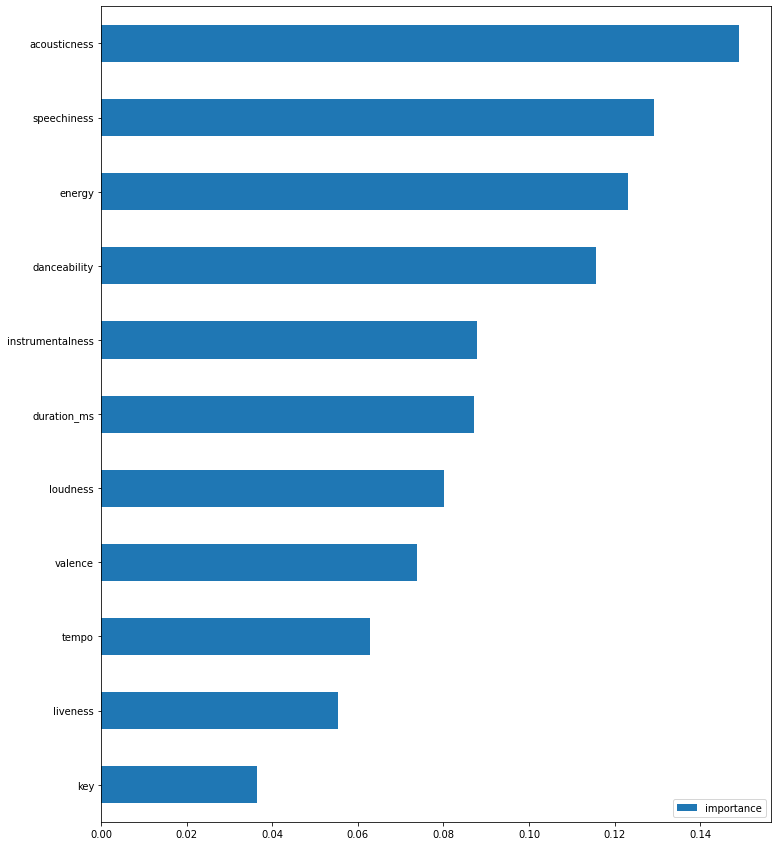

In [ ]:
importance = pd.DataFrame(clf.feature_importances_, index=X_train.columns, columns=['importance'])
importance.sort_values('importance').plot(kind='barh', figsize=(12, 15))